# Cài đặt thư viện cần thiết

In [ ]:
pip install matplotlib scikit-learn seaborn

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark findspark

In [ ]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
      .appName('data') \
      .getOrCreate()

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
from pyspark.sql.functions import col, sum, when, isnan

Côgn việc : Tiền xử lý dữ liệu (Data Preprocessing)
Đọc dữ liệu từ file (CSV/Excel Reader).

Kiểm tra thiếu dữ liệu (Missing Value, Column Filter).

Chuyển kiểu dữ liệu (String to Number, Number to String nếu cần).

Chuẩn hóa hoặc rút gọn cột không cần thiết.

Kết quả: Dữ liệu sạch, sẵn sàng để gán nhãn và train model.

Link mô tả file input : https://eagronin.github.io/capstone-acquire/

In [ ]:
spark_df = spark.read.option("header", True).option("inferSchema", True).csv("/content/catchThePinkFlamingo.csv")

In [ ]:
for col in spark_df.columns:
    spark_df = spark_df.withColumnRenamed(col, col.strip())

In [ ]:
spark_df.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   812|         5648|        1|     android|              69|         8|       NULL|     NULL|
|  1658|         5649|        1|      iphone|              31|         5|       NULL|     NULL|
|  1589|         5650|        1|      iphone|              26|         2|       NULL|     NULL|
|  1863|         5651|        1|     android|              35|         4|       NULL|     NULL|
|   937|         5652|        1|     android|              39|         0|          1|        1|
|   342|         5653|        1|     android|              36|         5|       NULL|     NULL|
|   849|         5654|        1|      iphone|              40|         5|       NULL|     NULL|
|  1277|         5655|        1|     win

In [ ]:
df = spark_df

In [ ]:
df.dtypes

[('userId', 'int'),
 ('userSessionId', 'int'),
 ('teamLevel', 'int'),
 ('platformType', 'string'),
 ('count_gameclicks', 'int'),
 ('count_hits', 'int'),
 ('count_buyId', 'string'),
 ('avg_price', 'string')]

In [ ]:
from pyspark.sql.functions import col, when, sum as Fsum


In [ ]:
df.select([
    Fsum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()


In [ ]:
df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|     0|            0|        0|           0|               0|         0|          0|        0|
+------+-------------+---------+------------+----------------+----------+-----------+---------+



In [ ]:
df.select([
    sum(when(isnan(col(c)), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|     0|            0|        0|           0|               0|         0|          0|        0|
+------+-------------+---------+------------+----------------+----------+-----------+---------+



In [ ]:
df.select([
    sum(when(col(c)=='NULL', 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|     0|            0|        0|           0|               0|         0|       3208|     3208|
+------+-------------+---------+------------+----------------+----------+-----------+---------+



In [ ]:
from pyspark.sql.functions import when, col, trim

df = df.withColumn("count_buyId", when(trim(col("count_buyId")) == "NULL", "0").otherwise(col("count_buyId")))
df = df.withColumn("avg_price", when(trim(col("avg_price")) == "NULL", "0").otherwise(col("avg_price")))

df = df.withColumn("count_buyId", col("count_buyId").cast("int"))
df = df.withColumn("avg_price", col("avg_price").cast("float"))

df = df.withColumn("made_purchase", when(col("count_buyId") > 0, 1).otherwise(0))


In [ ]:
df.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|made_purchase|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------+
|   812|         5648|        1|     android|              69|         8|          0|      0.0|            0|
|  1658|         5649|        1|      iphone|              31|         5|          0|      0.0|            0|
|  1589|         5650|        1|      iphone|              26|         2|          0|      0.0|            0|
|  1863|         5651|        1|     android|              35|         4|          0|      0.0|            0|
|   937|         5652|        1|     android|              39|         0|          1|      1.0|            1|
|   342|         5653|        1|     android|              36|         5|          0|      0.0|            0|
|   849|  

In [ ]:
user_stats = df.groupBy("userId", "platformType").agg(
    sum("count_buyId").alias("total_purchases"),
    sum(col("count_buyId") * col("avg_price")).alias("total_spent")
)

In [ ]:
user_stats.show()

+------+------------+---------------+------------------+
|userId|platformType|total_purchases|       total_spent|
+------+------------+---------------+------------------+
|  2229|      iphone|             15|223.01000213623047|
|   487|      iphone|              0|               0.0|
|  2116|     android|              0|               0.0|
|  1335|     windows|              0|               0.0|
|  1560|     android|              0|               0.0|
|  1471|      iphone|              8|              96.0|
|   908|         mac|              0|               0.0|
|   738|      iphone|              0|               0.0|
|    32|     android|              0|               0.0|
|   275|     android|              0|               0.0|
|   540|     android|              0|               0.0|
|   281|     android|              5|              34.0|
|  2323|     android|              0|               0.0|
|  1472|         mac|              1|              10.0|
|  1454|      iphone|          

Tạo input cho **KMINE**

In [ ]:
from pyspark.sql.functions import mean

user_stats.agg(mean("total_spent")).show()

+-----------------+
| avg(total_spent)|
+-----------------+
|15.37482356679925|
+-----------------+



In [ ]:
user_stats.coalesce(1).write.csv("/content/input2.csv", header=True)

Output sau khi phân nhãn và trực quan hoá dữ liệu ở **KMINE**

In [ ]:
df2 = spark.read.option("header", True).option("inferSchema", True).csv("/content/part-00000-72b64e25-854b-4d07-b3fa-bf386e06a3b4-c000.csv")

In [ ]:
df2.show()

+------+------------+---------------+------------------+---------+
|userId|platformType|total_purchases|       total_spent|  Cluster|
+------+------------+---------------+------------------+---------+
|  2229|      iphone|             15|223.01000213623047|cluster_0|
|   487|      iphone|              0|               0.0|cluster_1|
|  2116|     android|              0|               0.0|cluster_1|
|  1335|     windows|              0|               0.0|cluster_1|
|  1560|     android|              0|               0.0|cluster_1|
|  1471|      iphone|              8|              96.0|cluster_0|
|   908|         mac|              0|               0.0|cluster_1|
|   738|      iphone|              0|               0.0|cluster_1|
|    32|     android|              0|               0.0|cluster_1|
|   275|     android|              0|               0.0|cluster_1|
|   540|     android|              0|               0.0|cluster_1|
|   281|     android|              5|              34.0|cluste

In [ ]:
quantile = user_stats.approxQuantile("total_spent", [0.95], 0.01)[0]

In [ ]:
quantile

70.0

In [ ]:
user_stats = user_stats.withColumn(
    "spender_type",
    when(col("total_spent") >= 70, "big_spender").otherwise("low_spender")
)

In [ ]:
user_stats.show()

+------+------------+---------------+------------------+------------+
|userId|platformType|total_purchases|       total_spent|spender_type|
+------+------------+---------------+------------------+------------+
|  2229|      iphone|             15|223.01000213623047|  HighRoller|
|   487|      iphone|              0|               0.0|PennyPincher|
|  2116|     android|              0|               0.0|PennyPincher|
|  1335|     windows|              0|               0.0|PennyPincher|
|  1560|     android|              0|               0.0|PennyPincher|
|  1471|      iphone|              8|              96.0|  HighRoller|
|   908|         mac|              0|               0.0|PennyPincher|
|   738|      iphone|              0|               0.0|PennyPincher|
|    32|     android|              0|               0.0|PennyPincher|
|   275|     android|              0|               0.0|PennyPincher|
|   540|     android|              0|               0.0|PennyPincher|
|   281|     android

In [ ]:
df_with_stats = df.join(df2, on=["userId", "platformType"], how="left")

In [ ]:
df_with_stats.show()

+------+------------+-------------+---------+----------------+----------+-----------+---------+-------------+---------------+------------------+---------+
|userId|platformType|userSessionId|teamLevel|count_gameclicks|count_hits|count_buyId|avg_price|made_purchase|total_purchases|       total_spent|  Cluster|
+------+------------+-------------+---------+----------------+----------+-----------+---------+-------------+---------------+------------------+---------+
|   812|     android|         5648|        1|              69|         8|          0|      0.0|            0|              0|               0.0|cluster_1|
|  1658|      iphone|         5649|        1|              31|         5|          0|      0.0|            0|              5|              65.0|cluster_0|
|  1589|      iphone|         5650|        1|              26|         2|          0|      0.0|            0|              0|               0.0|cluster_1|
|  1863|     android|         5651|        1|              35|        

In [ ]:
df_with_stats = df_with_stats.withColumn(
    "Cluster",
    when(col("Cluster") == "cluster_0", "big_spender").otherwise("low_spender")
)
df_with_stats = df_with_stats.withColumnRenamed('Cluster', 'spender_type')


In [ ]:
df_with_stats.groupBy('spender_type').count().show()

+------------+-----+
|spender_type|count|
+------------+-----+
| big_spender|  770|
| low_spender| 3849|
+------------+-----+



In [ ]:
df_with_stats.groupBy('spender_type', 'teamLevel').count().orderBy('teamLevel', 'spender_type').show()

+------------+---------+-----+
|spender_type|teamLevel|count|
+------------+---------+-----+
| big_spender|        1|   82|
| low_spender|        1|  375|
| big_spender|        2|   94|
| low_spender|        2|  432|
| big_spender|        3|  102|
| low_spender|        3|  506|
| big_spender|        4|  117|
| low_spender|        4|  570|
| big_spender|        5|  128|
| low_spender|        5|  639|
| big_spender|        6|  129|
| low_spender|        6|  690|
| big_spender|        7|  117|
| low_spender|        7|  634|
| big_spender|        8|    1|
| low_spender|        8|    3|
+------------+---------+-----+



In [ ]:
from pyspark.sql.functions import avg, sum

df_with_stats.groupBy("spender_type").agg(
    avg("total_spent").alias("avg_spent"),
    sum("total_spent").alias("sum_spent")
).show()

+------------+-----------------+-----------------+
|spender_type|        avg_spent|        sum_spent|
+------------+-----------------+-----------------+
| big_spender| 86.1791171903734|66357.92023658752|
| low_spender|6.950857364285857|26753.84999513626|
+------------+-----------------+-----------------+



# Phân tích dữ liệu

### 2.1 Biểu đồ Số Lượt Click Trong Game theo Loại Nền Tảng và Phân Loại Người Dùng.

In [ ]:
scatter_data_spark_for_plot = df_with_stats.select("platformType", "count_gameclicks", "spender_type")
scatter_data_spark_for_plot.show()

+------------+----------------+------------+
|platformType|count_gameclicks|spender_type|
+------------+----------------+------------+
|     android|              69| low_spender|
|      iphone|              31| big_spender|
|      iphone|              26| low_spender|
|     android|              35| low_spender|
|     android|              39| low_spender|
|     android|              36| low_spender|
|      iphone|              40| low_spender|
|     windows|              46| low_spender|
|     android|              68| low_spender|
|      iphone|              76| low_spender|
|      iphone|              69| big_spender|
|      iphone|             129| big_spender|
|      iphone|              36| big_spender|
|     android|             102| low_spender|
|     android|             102| low_spender|
|      iphone|              63| low_spender|
|     android|             141| low_spender|
|     android|              39| low_spender|
|     android|              90| low_spender|
|      iph

In [ ]:
scatter_data_spark_for_plot2 = scatter_data_spark_for_plot.toPandas()

<Axes: xlabel='platformType', ylabel='count_gameclicks'>

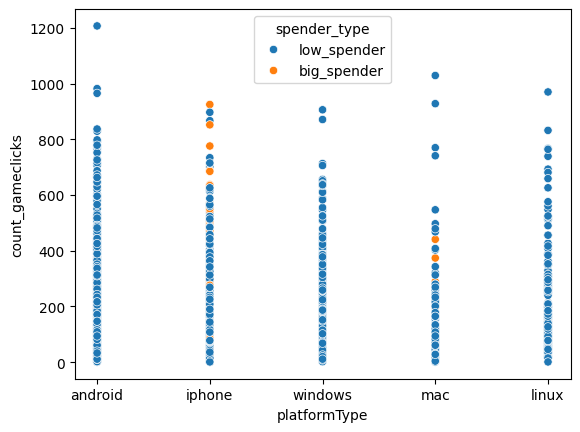

In [ ]:
sns.scatterplot(x='platformType',y='count_gameclicks',hue='spender_type',data=scatter_data_spark_for_plot2)

### 2.2 Biểu đồ số Lượng Người Dùng theo Loại Nền Tảng và Phân Loại Người Dùng.

In [ ]:
countplot_data_spark_agg = df_with_stats.groupBy("platformType", "spender_type").count().orderBy("platformType", "spender_type")
countplot_data_spark_agg.show()

+------------+------------+-----+
|platformType|spender_type|count|
+------------+------------+-----+
|     android| big_spender|   86|
|     android| low_spender| 1549|
|      iphone| big_spender|  663|
|      iphone| low_spender| 1271|
|       linux| low_spender|  252|
|         mac| big_spender|    7|
|         mac| low_spender|  172|
|     windows| big_spender|   14|
|     windows| low_spender|  605|
+------------+------------+-----+



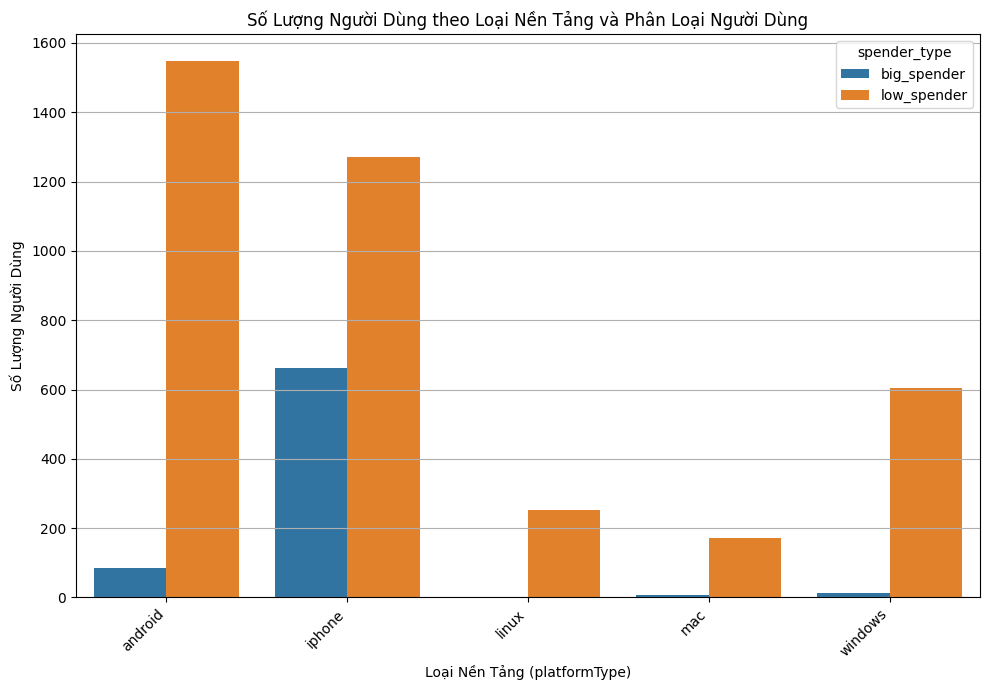

In [ ]:
import seaborn as sns
countplot_data_pd_agg = countplot_data_spark_agg.toPandas()

# # Vẽ biểu đồ cột bằng Seaborn
plt.figure(figsize=(10, 7))
sns.barplot(x='platformType', y='count', hue='spender_type', data=countplot_data_pd_agg)
plt.title('Số Lượng Người Dùng theo Loại Nền Tảng và Phân Loại Người Dùng')
plt.xlabel('Loại Nền Tảng (platformType)')
plt.ylabel('Số Lượng Người Dùng')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Biểu đồ cột cho thấy sự khác biệt rõ rệt về phân bố của PennyPinchers và HighRollers giữa các
nền tảng. Android và Windows bị chiếm đa số bởi PennyPinchers, trong khi iPhone bị chiếm đa số
bởi HighRollers. Mac và Linux có số lượng người dùng chung thấp hơn.
PlatformType là một đặc trưng rất quan trọng.

### 2.3 Bảng tương quan giữa các chỉ số

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

In [ ]:
numeric_cols_for_corr = ['userId', 'userSessionId', 'teamLevel', 'count_gameclicks', 'count_hits', 'count_buyId', 'avg_price']

In [ ]:
correlation_matrix= df_with_stats.select(numeric_cols_for_corr)
correlation_matrix.show()

+------+-------------+---------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+----------------+----------+-----------+---------+
|   812|         5648|        1|              69|         8|          0|      0.0|
|  1658|         5649|        1|              31|         5|          0|      0.0|
|  1589|         5650|        1|              26|         2|          0|      0.0|
|  1863|         5651|        1|              35|         4|          0|      0.0|
|   937|         5652|        1|              39|         0|          1|      1.0|
|   342|         5653|        1|              36|         5|          0|      0.0|
|   849|         5654|        1|              40|         5|          0|      0.0|
|  1277|         5655|        1|              46|         8|          0|      0.0|
|  2203|         5656|        1|              68|         6|          0|      0.0|
|   

In [ ]:
assembler = VectorAssembler(inputCols=correlation_matrix.columns, outputCol="corr_features_numeric_only", handleInvalid="skip")
vector_numeric = assembler.transform(correlation_matrix).select("corr_features_numeric_only")

In [ ]:
correlation_matrix= Correlation.corr(vector_numeric, "corr_features_numeric_only", "pearson").head()
print("\nMa trận tương quan (chỉ giữa các biến số ban đầu có trong df_with_stats):")
if correlation_matrix:
    correlation_pd_numeric_only = pd.DataFrame(
        correlation_matrix[0].toArray(),
        columns=numeric_cols_for_corr,
        index=numeric_cols_for_corr
    )
    print(correlation_pd_numeric_only.round(2))


Ma trận tương quan (chỉ giữa các biến số ban đầu có trong df_with_stats):
                  userId  userSessionId  teamLevel  count_gameclicks  \
userId              1.00           0.03      -0.00              0.07   
userSessionId       0.03           1.00       0.77              0.22   
teamLevel          -0.00           0.77       1.00             -0.08   
count_gameclicks    0.07           0.22      -0.08              1.00   
count_hits          0.07           0.22      -0.06              0.96   
count_buyId        -0.00           0.15       0.21              0.01   
avg_price           0.00           0.06       0.12             -0.00   

                  count_hits  count_buyId  avg_price  
userId                  0.07        -0.00       0.00  
userSessionId           0.22         0.15       0.06  
teamLevel              -0.06         0.21       0.12  
count_gameclicks        0.96         0.01      -0.00  
count_hits              1.00         0.04       0.04  
count_buyId       

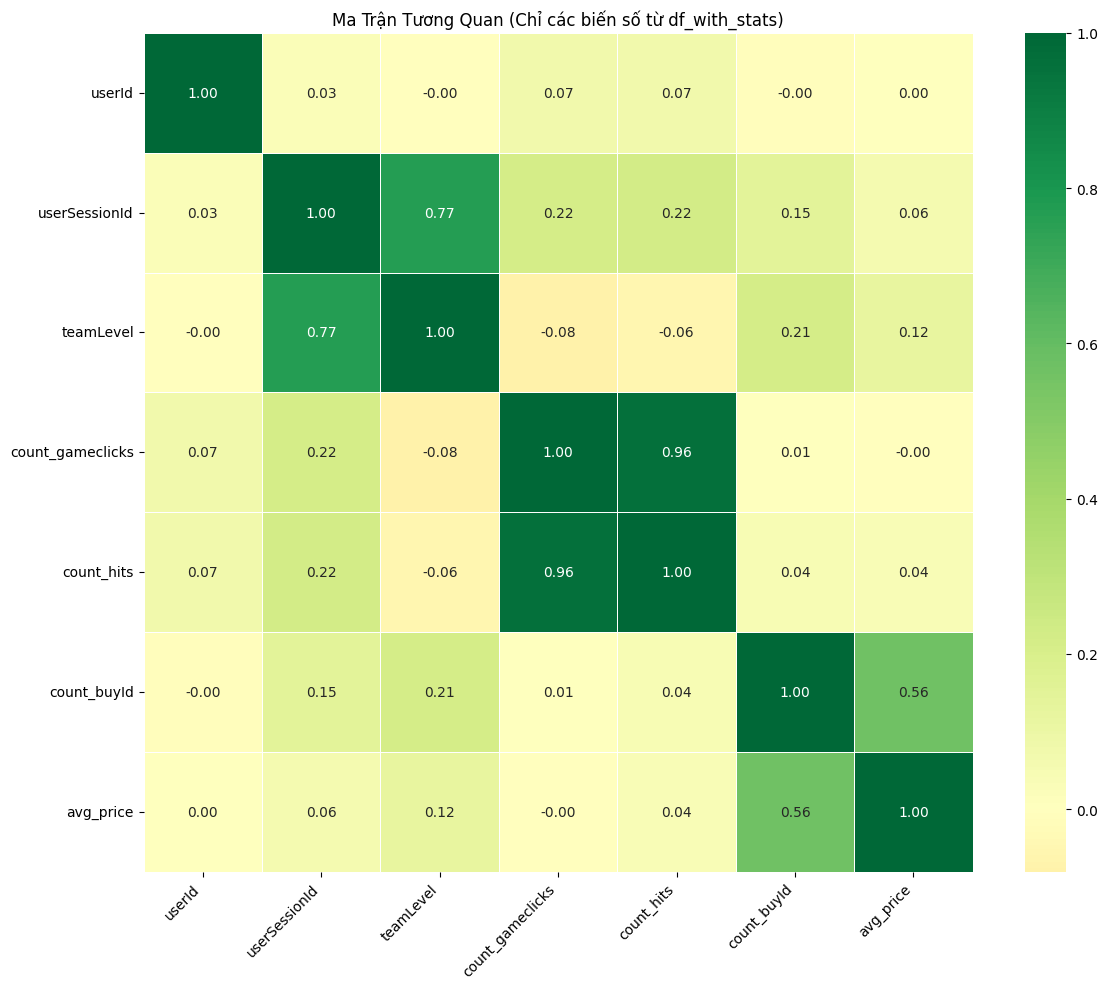

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_pd_numeric_only, annot=True, cmap='RdYlGn', fmt=".2f", linewidths=.5, center=0)
plt.title('Ma Trận Tương Quan (Chỉ các biến số từ df_with_stats)')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Ma trận tương quan cho thấy 'Tổng số lần nhấp vào trò chơi' (count_gameclicks) và 'Tổng số lần truy cập trò chơi' (count_hits) trong một phiên có mối tương quan dương rất mạnh (0.95).
#### 'ID phiên người dùng' (userSessionId) tương quan dương khá tốt với 'Cấp độ nhóm' (teamLevel) (0.78). 'teamLevel' cũng có tương quan dương yếu với 'Tổng số lần mua' (count_buyId) (0.27).
#### Đáng chú ý, 'Giá mua trung bình' (avg_price) gần như không tương quan với các chỉ số hoạt động khác. Điều này ngụ ý rằng, chỉ dựa trên các hành vi này, khó có thể dự đoán trực tiếp liệu giá trị trung bình của giao dịch sẽ cao hay thấp.

### 2.4 Khoảng giá trung bình mà người dùng tiêu ( theo thiết bị )

In [ ]:
boxplot_avg_price_spark = df_with_stats.select("platformType", "avg_price").filter(col("avg_price") > 0)

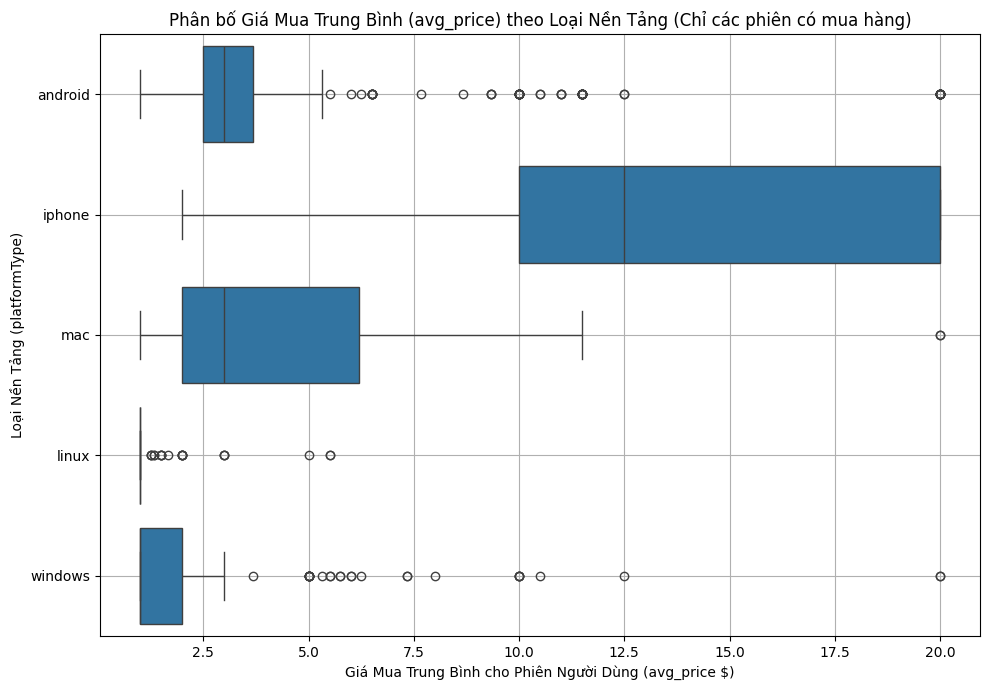

In [ ]:
boxplot_avg_price_pd = boxplot_avg_price_spark.toPandas()

plt.figure(figsize=(10, 7))
sns.boxplot(x='avg_price', y='platformType', data=boxplot_avg_price_pd)
plt.title('Phân bố Giá Mua Trung Bình (avg_price) theo Loại Nền Tảng (Chỉ các phiên có mua hàng)')
plt.xlabel('Giá Mua Trung Bình cho Phiên Người Dùng (avg_price $)')
plt.ylabel('Loại Nền Tảng (platformType)')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Biểu đồ hộp của avg_price theo từng nền tảng (chỉ xét các phiên có mua hàng) cho thấy sự khác biệt trong phân bố giá trị chi tiêu. Người dùng iPhone có xu hướng có khoảng tứ phân vị (IQR) và các giá trị ngoại lệ ở mức giá cao hơn so với các nền tảng khác.
#### Android và Windows có vẻ có phân bố giá rộng hơn ở các mức thấp và trung bình. Mac và Linux có ít dữ liệu hơnnhưng cũng cho thấy sự tập trung ở các mức giá thấp hơn so với iPhone.Điều này củng cố rằng platformType, đặc biệt là iPhone, có liên quan đến khả năng chi tiêu cao hơn.

# Phần 3


In [ ]:
df_with_stats.groupBy("spender_type", "teamLevel").count().orderBy("spender_type", "teamLevel").show()

+------------+---------+-----+
|spender_type|teamLevel|count|
+------------+---------+-----+
| big_spender|        1|   82|
| big_spender|        2|   94|
| big_spender|        3|  102|
| big_spender|        4|  117|
| big_spender|        5|  128|
| big_spender|        6|  129|
| big_spender|        7|  117|
| big_spender|        8|    1|
| low_spender|        1|  375|
| low_spender|        2|  432|
| low_spender|        3|  506|
| low_spender|        4|  570|
| low_spender|        5|  639|
| low_spender|        6|  690|
| low_spender|        7|  634|
| low_spender|        8|    3|
+------------+---------+-----+



In [ ]:
df_with_stats.groupBy("spender_type", "userSessionId").count().orderBy("spender_type", "userSessionId").show()

+------------+-------------+-----+
|spender_type|userSessionId|count|
+------------+-------------+-----+
| big_spender|         5649|    1|
| big_spender|         5658|    1|
| big_spender|         5659|    1|
| big_spender|         5660|    1|
| big_spender|         5671|    1|
| big_spender|         5674|    1|
| big_spender|         5679|    1|
| big_spender|         5694|    1|
| big_spender|         5696|    1|
| big_spender|         5702|    1|
| big_spender|         5706|    1|
| big_spender|         5707|    1|
| big_spender|         5709|    1|
| big_spender|         5715|    1|
| big_spender|         5720|    1|
| big_spender|         5724|    1|
| big_spender|         5734|    1|
| big_spender|         5743|    1|
| big_spender|         5746|    1|
| big_spender|         5764|    1|
+------------+-------------+-----+
only showing top 20 rows



user session id ko ảnh hưởng

In [ ]:
df_with_stats.groupBy("spender_type", "platformType").count().orderBy("spender_type", "platformType").show()

+------------+------------+-----+
|spender_type|platformType|count|
+------------+------------+-----+
| big_spender|     android|   86|
| big_spender|      iphone|  663|
| big_spender|         mac|    7|
| big_spender|     windows|   14|
| low_spender|     android| 1549|
| low_spender|      iphone| 1271|
| low_spender|       linux|  252|
| low_spender|         mac|  172|
| low_spender|     windows|  605|
+------------+------------+-----+



In [ ]:
df_with_stats.show()

+------+------------+-------------+---------+----------------+----------+-----------+---------+-------------+---------------+------------------+------------+
|userId|platformType|userSessionId|teamLevel|count_gameclicks|count_hits|count_buyId|avg_price|made_purchase|total_purchases|       total_spent|spender_type|
+------+------------+-------------+---------+----------------+----------+-----------+---------+-------------+---------------+------------------+------------+
|   812|     android|         5648|        1|              69|         8|          0|      0.0|            0|              0|               0.0| low_spender|
|  1658|      iphone|         5649|        1|              31|         5|          0|      0.0|            0|              5|              65.0| big_spender|
|  1589|      iphone|         5650|        1|              26|         2|          0|      0.0|            0|              0|               0.0| low_spender|
|  1863|     android|         5651|        1|       

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

window = Window.partitionBy("userId").orderBy("userSessionId")
df_early = df_with_stats.withColumn("session_rank", row_number().over(window)).filter("session_rank <= 3")

In [ ]:
df_early.show()

+------+------------+-------------+---------+----------------+----------+-----------+---------+-------------+---------------+------------------+------------+------------+
|userId|platformType|userSessionId|teamLevel|count_gameclicks|count_hits|count_buyId|avg_price|made_purchase|total_purchases|       total_spent|spender_type|session_rank|
+------+------------+-------------+---------+----------------+----------+-----------+---------+-------------+---------------+------------------+------------+------------+
|     0|      iphone|        23473|        1|             237|        28|          0|      0.0|            0|              0|               0.0| low_spender|           1|
|     0|      iphone|        24943|        2|             353|        35|          0|      0.0|            0|              0|               0.0| low_spender|           2|
|     0|      iphone|        28377|        3|             381|        32|          0|      0.0|            0|              0|               0.0| 

In [ ]:
df_early.groupby('userId', 'platformType').count().show()

+------+------------+-----+
|userId|platformType|count|
+------+------------+-----+
|     0|      iphone|    3|
|     1|     android|    3|
|     2|      iphone|    3|
|     6|      iphone|    1|
|     8|      iphone|    2|
|     9|      iphone|    3|
|    10|       linux|    3|
|    12|      iphone|    3|
|    13|     android|    2|
|    14|       linux|    1|
|    15|     windows|    2|
|    16|     android|    3|
|    17|     android|    2|
|    20|      iphone|    1|
|    21|     android|    3|
|    23|     android|    3|
|    25|         mac|    3|
|    26|     windows|    2|
|    27|         mac|    1|
|    28|      iphone|    3|
+------+------------+-----+
only showing top 20 rows



In [ ]:
import pyspark.sql.functions as F
platform_users = df_early.select("userId", "platformType") \
    .distinct() \
    .groupBy("userId") \
    .agg(F.countDistinct("platformType").alias("num_platforms")) \
    .filter("num_platforms >= 2")
platform_users.show()

+------+-------------+
|userId|num_platforms|
+------+-------------+
|   835|            2|
|   967|            2|
|  1265|            2|
|  1267|            2|
|  1760|            2|
|  1933|            2|
+------+-------------+



In [ ]:
df = df_early.join(platform_users, on="userId", how="left_anti")

In [ ]:
from pyspark.sql.functions import avg, sum, max, count
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler

In [ ]:
agg_df = df.groupBy("userId", "platformType").agg(
    F.avg("count_gameclicks").alias("avg_clicks"),
    F.avg("count_hits").alias("avg_hits"),
    F.sum("count_buyId").alias("total_early_buys"),
    F.avg("avg_price").alias("early_avg_price"),
    F.max("made_purchase").alias("has_early_purchase"),
    F.count("*").alias("session_count")
)


In [ ]:
agg_df.show()

+------+------------+------------------+------------------+----------------+------------------+------------------+-------------+
|userId|platformType|        avg_clicks|          avg_hits|total_early_buys|   early_avg_price|has_early_purchase|session_count|
+------+------------+------------------+------------------+----------------+------------------+------------------+-------------+
|     0|      iphone| 323.6666666666667|31.666666666666668|               0|               0.0|                 0|            3|
|     1|     android|              87.0|              10.0|               2|               1.0|                 1|            3|
|     2|      iphone|              27.0|               3.0|               0|               0.0|                 0|            3|
|     6|      iphone|              90.0|               5.0|               0|               0.0|                 0|            1|
|     8|      iphone|             103.5|              12.0|               3|               5.5|  

In [ ]:
df_temp = agg_df.join(df, on=['userId', 'platformType'], how='left')

In [ ]:
df_temp = df_temp.drop('userSessionId','count_gameclicks','count_hits', 'count_buyId', 'avg_price', 'made_purchase','total_purchases','total_spent','has_early_purchase', 'session_rank')

In [ ]:
df_temp.show()

+------+------------+-----------------+------------------+----------------+------------------+-------------+---------+------------+
|userId|platformType|       avg_clicks|          avg_hits|total_early_buys|   early_avg_price|session_count|teamLevel|spender_type|
+------+------------+-----------------+------------------+----------------+------------------+-------------+---------+------------+
|     0|      iphone|323.6666666666667|31.666666666666668|               0|               0.0|            3|        3| low_spender|
|     0|      iphone|323.6666666666667|31.666666666666668|               0|               0.0|            3|        2| low_spender|
|     0|      iphone|323.6666666666667|31.666666666666668|               0|               0.0|            3|        1| low_spender|
|     1|     android|             87.0|              10.0|               2|               1.0|            3|        3| low_spender|
|     1|     android|             87.0|              10.0|               2| 

In [ ]:
df_temp.dtypes

[('userId', 'int'),
 ('platformType', 'string'),
 ('avg_clicks', 'double'),
 ('avg_hits', 'double'),
 ('total_early_buys', 'bigint'),
 ('early_avg_price', 'double'),
 ('session_count', 'bigint'),
 ('teamLevel', 'int'),
 ('spender_type', 'string')]

In [ ]:
team_feature = df_temp.groupBy("userId").agg(
    max("teamLevel").cast("int").alias("max_teamLevel")
)

In [ ]:
final_features = df_temp.join(team_feature, on="userId", how="left")

In [ ]:
final_features = final_features.drop('teamLevel').distinct()

In [ ]:
final_features.show()

+------+------------+------------------+------------------+----------------+------------------+-------------+------------+-------------+
|userId|platformType|        avg_clicks|          avg_hits|total_early_buys|   early_avg_price|session_count|spender_type|max_teamLevel|
+------+------------+------------------+------------------+----------------+------------------+-------------+------------+-------------+
|     0|      iphone| 323.6666666666667|31.666666666666668|               0|               0.0|            3| low_spender|            3|
|     1|     android|              87.0|              10.0|               2|               1.0|            3| low_spender|            3|
|     2|      iphone|              27.0|               3.0|               0|               0.0|            3| low_spender|            5|
|     6|      iphone|              90.0|               5.0|               0|               0.0|            1| low_spender|            7|
|     8|      iphone|             103.5| 

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import StandardScaler

In [ ]:
spender_indexer = StringIndexer(inputCol="spender_type", outputCol="spender_type_index")
platform_indexer = StringIndexer(inputCol="platformType", outputCol="platform_index")
final_features = spender_indexer.fit(final_features).transform(final_features)
final_features = platform_indexer.fit(final_features).transform(final_features)

In [ ]:
final_features = final_features.drop('platformType','spender_type')

In [ ]:
final_features.show()

+------+------------------+------------------+----------------+------------------+-------------+-------------+------------------+--------------+
|userId|        avg_clicks|          avg_hits|total_early_buys|   early_avg_price|session_count|max_teamLevel|spender_type_index|platform_index|
+------+------------------+------------------+----------------+------------------+-------------+-------------+------------------+--------------+
|     0| 323.6666666666667|31.666666666666668|               0|               0.0|            3|            3|               0.0|           0.0|
|     1|              87.0|              10.0|               2|               1.0|            3|            3|               0.0|           1.0|
|     2|              27.0|               3.0|               0|               0.0|            3|            5|               0.0|           0.0|
|     6|              90.0|               5.0|               0|               0.0|            1|            7|               0.0| 

In [ ]:
encoder = OneHotEncoder(
    inputCols=[ "platform_index"],
    outputCols=[ "platform_ohe"]
)
final_features = encoder.fit(final_features).transform(final_features)

In [ ]:
final_features = final_features.drop('platform_index')

In [ ]:
numeric_cols = [
    "avg_clicks",
    "avg_hits",
    "total_early_buys",
    "early_avg_price",
    "session_count",
    "max_teamLevel"
]

pre_assembled = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_vector").transform(final_features)

scaler = StandardScaler(inputCol="numeric_vector", outputCol="scaled_numeric", withMean=True, withStd=True)
scaler_model = scaler.fit(pre_assembled)
scaled_df = scaler_model.transform(pre_assembled)
final_assembler = VectorAssembler(
    inputCols=[
    "scaled_numeric",
    "max_teamLevel", "platform_ohe"],
    outputCol="features"
)
final_df = final_assembler.transform(scaled_df)


In [ ]:
final_df.show()

+------+------------------+------------------+----------------+------------------+-------------+-------------+------------------+-------------+--------------------+--------------------+--------------------+
|userId|        avg_clicks|          avg_hits|total_early_buys|   early_avg_price|session_count|max_teamLevel|spender_type_index| platform_ohe|      numeric_vector|      scaled_numeric|            features|
+------+------------------+------------------+----------------+------------------+-------------+-------------+------------------+-------------+--------------------+--------------------+--------------------+
|     0| 323.6666666666667|31.666666666666668|               0|               0.0|            3|            3|               0.0|(4,[0],[1.0])|[323.666666666666...|[1.41554519523660...|[1.41554519523660...|
|     1|              87.0|              10.0|               2|               1.0|            3|            3|               0.0|(4,[1],[1.0])|[87.0,10.0,2.0,1....|[-0.4393

In [ ]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

# Phần 4: Models

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lr = LogisticRegression(
    featuresCol="features",
    labelCol="spender_type_index",
    predictionCol="prediction",
    maxIter=20
)

lr_model = lr.fit(train_df)
predictions = lr_model.transform(train_df)

evaluator = MulticlassClassificationEvaluator(
    labelCol="spender_type_index",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Train Accuracy (LogReg) = {accuracy:.4f}")


Train Accuracy (LogReg) = 0.9545


In [ ]:
predictions = lr_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(
    labelCol="spender_type_index",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy (LogReg) = {accuracy:.4f}")

Test Accuracy (LogReg) = 0.9293


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="spender_type_index"
)

model = dt.fit(train_df)
predictions = model.transform(train_df)

accuracy_eval = MulticlassClassificationEvaluator(
    labelCol="spender_type_index",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = accuracy_eval.evaluate(predictions)

auc_eval = BinaryClassificationEvaluator(
    labelCol="spender_type_index",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
auc = auc_eval.evaluate(predictions)

print(f"Decision Tree - Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")


Decision Tree - Accuracy = 0.9645, AUC = 0.8595


In [ ]:
dt = DecisionTreeClassifier(
    featuresCol='features',
    labelCol='spender_type_index',
    maxDepth=6,
    maxBins=64
)

In [ ]:
model = dt.fit(train_df)
predictions = model.transform(train_df)

In [ ]:
accuracy = accuracy_eval.evaluate(predictions)

In [ ]:
auc = auc_eval.evaluate(predictions)

In [ ]:
print(f"Decision Tree - Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")

Decision Tree - Accuracy = 0.9402, AUC = 0.7023


In [ ]:
predictions = model.transform(test_df)
accuracy = accuracy_eval.evaluate(predictions)
auc = auc_eval.evaluate(predictions)
print(f"Decision Tree - Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")

Decision Tree - Accuracy = 0.9402, AUC = 0.7023


In [ ]:
dt = DecisionTreeClassifier(
    featuresCol='features',
    labelCol='spender_type_index',
    maxDepth=7,
    maxBins=64
)

In [ ]:
model = dt.fit(train_df)
predictions = model.transform(train_df)
accuracy = accuracy_eval.evaluate(predictions)
auc = auc_eval.evaluate(predictions)
print(f"Decision Tree Train - Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")

Decision Tree Train - Accuracy = 0.9767, AUC = 0.7611


In [ ]:
predictions = model.transform(test_df)
accuracy = accuracy_eval.evaluate(predictions)
auc = auc_eval.evaluate(predictions)
print(f"Decision Tree - Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")

Decision Tree - Accuracy = 0.9457, AUC = 0.6734


In [ ]:
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="spender_type_index",
    numTrees=50
)

In [ ]:
model = rf.fit(train_df)
predictions = model.transform(train_df)
accuracy = accuracy_eval.evaluate(predictions)
auc = auc_eval.evaluate(predictions)
print(f"Decision Tree Train - Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")

Decision Tree Train - Accuracy = 0.9612, AUC = 0.9729


In [ ]:
predictions = model.transform(test_df)
accuracy = accuracy_eval.evaluate(predictions)
auc = auc_eval.evaluate(predictions)
print(f"Decision Tree - Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")

Decision Tree - Accuracy = 0.9348, AUC = 0.9592


In [ ]:
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="spender_type_index",
    numTrees=100
)

In [ ]:
model = rf.fit(train_df)
predictions = model.transform(train_df)
accuracy = accuracy_eval.evaluate(predictions)
auc = auc_eval.evaluate(predictions)
print(f"RandomForest Train - Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")

RandomForest Train - Accuracy = 0.9645, AUC = 0.9784


In [ ]:
predictions = model.transform(test_df)
accuracy = accuracy_eval.evaluate(predictions)
auc = auc_eval.evaluate(predictions)
print(f"RandomForest Tree - Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")

RandomForest Tree - Accuracy = 0.9402, AUC = 0.9626


In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(
    featuresCol="features",
    labelCol="spender_type_index",
    maxIter=3,
    maxDepth=3,
    stepSize=0.8
)
model = gbt.fit(train_df)
predictions = model.transform(train_df)
accuracy = accuracy_eval.evaluate(predictions)
auc = auc_eval.evaluate(predictions)
print(f"GBT Train - Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")
predictions = model.transform(test_df)
accuracy = accuracy_eval.evaluate(predictions)
auc = auc_eval.evaluate(predictions)
print(f"GBT Test - Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
from pyspark.sql.functions import when, lit
total = 3849 + 770
weight1 = total / (2 * 3849)
weight2 = total / (2 * 770)
train_df = train_df.withColumn(
    "classWeightCol",
    when(train_df["spender_type_index"] == 0, lit(weight1))
    .otherwise(lit(weight2))
)

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="spender_type_index",
    weightCol="classWeightCol",
    maxIter=100
)

lr_model = lr.fit(train_df)
predictions = lr_model.transform(train_df)
evaluator = MulticlassClassificationEvaluator(
    labelCol="spender_type_index",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Train Accuracy (LogReg) = {accuracy:.4f}")

auc_eval = BinaryClassificationEvaluator(
    labelCol="spender_type_index",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = auc_eval.evaluate(predictions)
print(f"AUC (LogReg Weighted) = {auc:.4f}")
predictions = lr_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(
    labelCol="spender_type_index",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy (LogReg) = {accuracy:.4f}")
auc = auc_eval.evaluate(predictions)
print(f"AUC (LogReg Weighted) = {auc:.4f}")

Train Accuracy (LogReg) = 0.9290
AUC (LogReg Weighted) = 0.9647
Test Accuracy (LogReg) = 0.9022
AUC (LogReg Weighted) = 0.9587


In [ ]:
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="spender_type_index",
    weightCol="classWeightCol",
    numTrees=90,
    maxDepth=15,
    maxBins=64
)
rf_model = rf.fit(train_df)
train_preds = rf_model.transform(train_df)

acc_eval = MulticlassClassificationEvaluator(
    labelCol="spender_type_index",
    predictionCol="prediction",
    metricName="accuracy"
)
train_acc = acc_eval.evaluate(train_preds)

auc_eval = BinaryClassificationEvaluator(
    labelCol="spender_type_index",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
train_auc = auc_eval.evaluate(train_preds)

print(f"[Train] Random Forest - Accuracy = {train_acc:.4f}, AUC = {train_auc:.4f}")

test_preds = rf_model.transform(test_df)

acc_eval = MulticlassClassificationEvaluator(
    labelCol="spender_type_index",
    predictionCol="prediction",
    metricName="accuracy"
)
test_acc = acc_eval.evaluate(test_preds)

auc_eval = BinaryClassificationEvaluator(
    labelCol="spender_type_index",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
test_auc = auc_eval.evaluate(test_preds)

print(f"[Test] Random Forest - Accuracy = {test_acc:.4f}, AUC = {test_auc:.4f}")


[Train] Random Forest - Accuracy = 0.9878, AUC = 0.9993
[Test] Random Forest - Accuracy = 0.9402, AUC = 0.9699


In [ ]:
gbt = GBTClassifier(
    featuresCol="features",
    labelCol="spender_type_index",
    weightCol="classWeightCol",
    maxIter=40,
    maxDepth=5,
    stepSize=0.7
)
model = gbt.fit(train_df)
predictions = model.transform(train_df)
accuracy = accuracy_eval.evaluate(predictions)
auc = auc_eval.evaluate(predictions)
print(f"GBT Train - Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")
predictions = model.transform(test_df)
accuracy = accuracy_eval.evaluate(predictions)
auc = auc_eval.evaluate(predictions)
print(f"GBT Test - Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")


GBT Train - Accuracy = 0.9956, AUC = 0.9999
GBT Test - Accuracy = 0.9348, AUC = 0.9526
